## Exercici 1
Agafa el conjunt de dades que vulguis i realitza un pipeline i un gridsearch aplicant l'algorisme de Random Forest.

In [1]:
import pandas as pd
import numpy as np

df_birds = pd.read_csv("bird_migration.csv")

display(df_birds.head())
df_birds.info()

,Unnamed: 0,altitude,date_time,device_info_serial,direction,latitude,longitude,speed_2d,bird_name
0,0,71,2013-08-15 00:18:08+00,851,-150.469753,49.419860,2.120733,0.150000,Eric
1,1,68,2013-08-15 00:48:07+00,851,-136.151141,49.419880,2.120746,2.438360,Eric
2,2,68,2013-08-15 01:17:58+00,851,160.797477,49.420310,2.120885,0.596657,Eric
3,3,73,2013-08-15 01:47:51+00,851,32.769360,49.420359,2.120859,0.310161,Eric
4,4,69,2013-08-15 02:17:42+00,851,45.191230,49.420331,2.120887,0.193132,Eric


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61920 entries, 0 to 61919
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          61920 non-null  int64  
 1   altitude            61920 non-null  int64  
 2   date_time           61920 non-null  object 
 3   device_info_serial  61920 non-null  int64  
 4   direction           61477 non-null  float64
 5   latitude            61920 non-null  float64
 6   longitude           61920 non-null  float64
 7   speed_2d            61477 non-null  float64
 8   bird_name           61920 non-null  object 
dtypes: float64(4), int64(3), object(2)
memory usage: 4.3+ MB


La columna Unnamed:0 es como un Id, así que no nos aporta información.

In [2]:
df_birds = df_birds.drop(columns = ['Unnamed: 0'])

Compruebo la existencia de valores nulos

In [3]:
count_nan_in_df = df_birds.isnull().sum()
print(count_nan_in_df)

altitude                0
date_time               0
device_info_serial      0
direction             443
latitude                0
longitude               0
speed_2d              443
bird_name               0
dtype: int64


Las únicas columnas con valores nulos son direction y speed_2d. Además, el número de valores nulos coincide. Compruebo si los valores se corresponden.

In [4]:
df_nan = df_birds.loc[(df_birds['direction'].isna() == True) & (df_birds['speed_2d'].isna() == True)]
display(df_nan)

,altitude,date_time,device_info_serial,direction,latitude,longitude,speed_2d,bird_name
219,333,2013-08-17 14:53:28+00,851,NaN,50.059118,2.313576,NaN,Eric
1005,60,2013-08-27 03:49:51+00,851,NaN,49.937367,2.269356,NaN,Eric
1231,96,2013-08-29 19:03:23+00,851,NaN,50.194337,2.739221,NaN,Eric
1254,108,2013-08-30 03:49:33+00,851,NaN,50.192476,2.735606,NaN,Eric
1530,135,2013-09-02 10:52:35+00,851,NaN,50.209139,2.634229,NaN,Eric
...,...,...,...,...,...,...,...,...
61161,9,2014-04-20 21:55:57+00,833,NaN,51.349591,3.171591,NaN,Sanne
61166,0,2014-04-21 00:26:40+00,833,NaN,51.347476,3.173766,NaN,Sanne
61672,28,2014-04-27 16:49:01+00,833,NaN,51.067792,3.279343,NaN,Sanne
61702,37,2014-04-28 04:07:53+00,833,NaN,51.323376,3.210039,NaN,Sanne


Efectivamente, las filas para las que direction y speed_2d son nulos son las mismas. El hecho de que estos valores sean nulos indica una falta de datos acerca de la trayectoria del ave, lo que puede significar que el ave estuviera detenida en algún lugar, comiendo o descansando. Por tanto, podemos sustituir estos valores nulos por 0.

In [5]:
df_birds = df_birds.fillna(0)

Transformo la columna datetime, separándola en valores numéricos de acuerdo con año, mes, día, hora, minutos y segundos, para que pueda ser manejable por el modelo Random Forest

In [6]:
df_birds['year'] = pd.to_datetime(df_birds['date_time']).dt.year
df_birds['month'] = pd.to_datetime(df_birds['date_time']).dt.month
df_birds['day'] = pd.to_datetime(df_birds['date_time']).dt.day
df_birds['hour'] = pd.to_datetime(df_birds['date_time']).dt.hour
df_birds['minutes'] = pd.to_datetime(df_birds['date_time']).dt.minute
df_birds['seconds'] = pd.to_datetime(df_birds['date_time']).dt.second
display(df_birds)

,altitude,date_time,device_info_serial,direction,latitude,longitude,speed_2d,bird_name,year,month,day,hour,minutes,seconds
0,71,2013-08-15 00:18:08+00,851,-150.469753,49.419860,2.120733,0.150000,Eric,2013,8,15,0,18,8
1,68,2013-08-15 00:48:07+00,851,-136.151141,49.419880,2.120746,2.438360,Eric,2013,8,15,0,48,7
2,68,2013-08-15 01:17:58+00,851,160.797477,49.420310,2.120885,0.596657,Eric,2013,8,15,1,17,58
3,73,2013-08-15 01:47:51+00,851,32.769360,49.420359,2.120859,0.310161,Eric,2013,8,15,1,47,51
4,69,2013-08-15 02:17:42+00,851,45.191230,49.420331,2.120887,0.193132,Eric,2013,8,15,2,17,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61915,11,2014-04-30 22:00:08+00,833,45.448157,51.352572,3.177151,0.208087,Sanne,2014,4,30,22,0,8
61916,6,2014-04-30 22:29:57+00,833,-112.073055,51.352585,3.177144,1.522662,Sanne,2014,4,30,22,29,57
61917,5,2014-04-30 22:59:52+00,833,69.989037,51.352622,3.177257,3.120545,Sanne,2014,4,30,22,59,52
61918,16,2014-04-30 23:29:43+00,833,88.376373,51.354641,3.181509,0.592115,Sanne,2014,4,30,23,29,43


In [7]:
df_birds = df_birds.drop(columns = ['date_time'])

Compruebo que el número de observaciones de cada ave esté equilibrado

Nico     21121
Sanne    21004
Eric     19795
Name: bird_name, dtype: int64

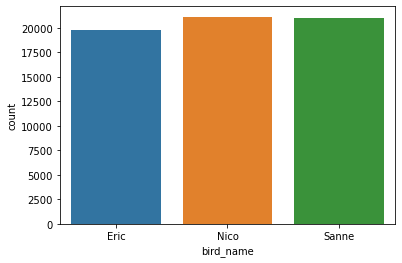

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

display(df_birds.bird_name.value_counts())

sns.countplot(x="bird_name", data=df_birds)
plt.show()

Separo las variables de las etiquetas

In [9]:
X = df_birds.drop(['bird_name'],axis=1)
Y = df_birds['bird_name']

Compruebo la presencia de outliers en el dataset para decidir cómo gestionarlos a la hora de estandarizar los datos

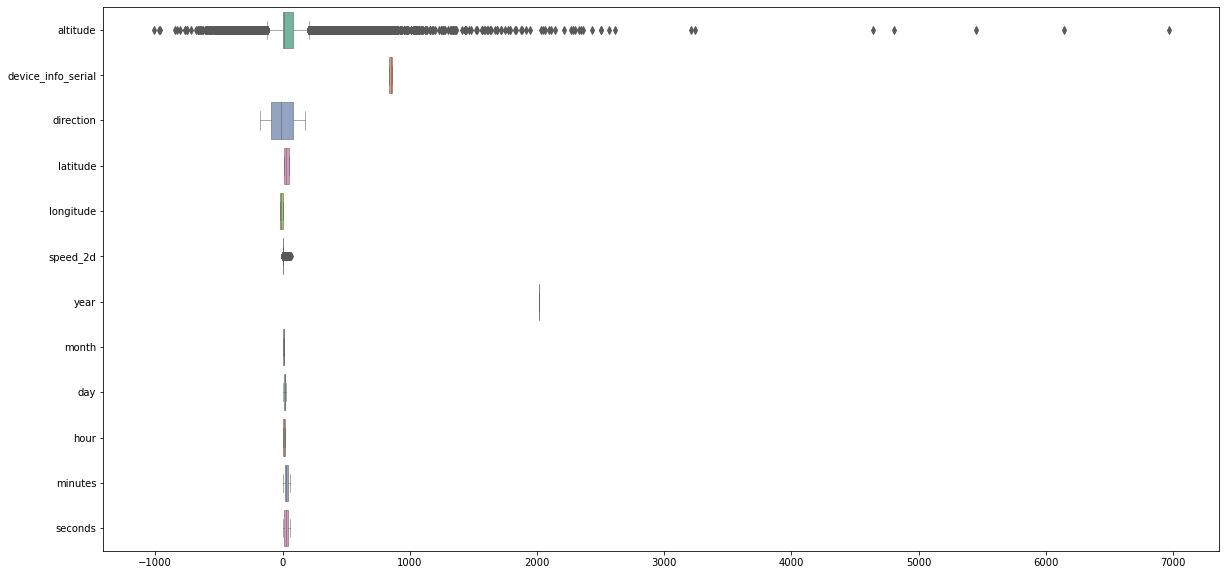

In [10]:
import seaborn as sns
    
ax = sns.boxplot(data=X, orient="h", palette="Set2", linewidth=0.5)
plt.gcf().set_size_inches(20, 10)

A excepción de altitude, prácticamente no puede apreciarse presencia de outliers en las variables. Sin embargo, la cantidad de outliers en altitude es muy notable. Por tanto, optaré por RobustScaler. El RobustScaler impide que los valores atípicos distorsionen los resultados ya que elimina la mediana y escala los datos de acuerdo con el rango IQR (el rango entre el primer cuartil, 25, y el tercer cuartil, 75).

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

steps = [('scaler', RobustScaler()), ('RandomForest', RandomForestClassifier(random_state=27))]
pipeline = Pipeline(steps)

Divido el dataset en train y test y aplico stratify para solventar el hecho de que las cantidades de las muestras para cada ave no sean exactamente las mismas

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=30, stratify=Y)

Determino los parámetros que quiero considerar en el modelo y averiguo cuáles son los que mejor resultado dan

In [13]:
from sklearn.model_selection import GridSearchCV

parameteres = {'RandomForest__n_estimators':[100,200,500], 'RandomForest__criterion':['gini','entropy']}
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5)
grid.fit(X_train, y_train)
print(grid.score(X_test,y_test))
print(grid.best_params_)

1.0
{'RandomForest__criterion': 'gini', 'RandomForest__n_estimators': 100}


## Exercici 2
Agafa un text en anglès que vulguis, i calcula'n la freqüència de les paraules

Fuente del texto: https://theconversation.com/altruism-in-birds-magpies-have-outwitted-scientists-by-helping-each-other-remove-tracking-devices-175246

In [14]:
text_birds = open("birds.txt", "r")
print(text_birds.readlines())

['When we attached tiny, backpack-like tracking devices to five Australian magpies for a pilot study, we didn’t expect to discover an entirely new social behaviour rarely seen in birds.\n', '\n', 'Our goal was to learn more about the movement and social dynamics of these highly intelligent birds, and to test these new, durable and reusable devices. Instead, the birds outsmarted us.\n', '\n', 'As our new research paper explains, the magpies began showing evidence of cooperative “rescue” behaviour to help each other remove the tracker.\n', '\n', 'While we’re familiar with magpies being intelligent and social creatures, this was the first instance we knew of that showed this type of seemingly altruistic behaviour: helping another member of the group without getting an immediate, tangible reward.\n', '\n', 'Testing exciting new devices\n', 'As academic scientists, we’re accustomed to experiments going awry in one way or another. Expired substances, failing equipment, contaminated samples, 

En primer lugar, extraigo todas las palabras del texto

In [15]:
from nltk.tokenize import word_tokenize, sent_tokenize
import re

tokens = [] # Lista contenedora de todos los tokens del texto

with open('birds.txt', 'r') as text_birds:
    sent_tokenized_text = sent_tokenize(text_birds.read()) # Divido el texto en oraciones
    for sentence in sent_tokenized_text:
        if sentence != '\n': # Hay líneas que contienen los espacios entre párrafos, así que las ignoro
            word_tokenized_text = word_tokenize(sentence) # Tokenizo cada oración
            for word in word_tokenized_text: 
                word = word.lower()
                word = re.sub(r'[^\w\s]', '', word) # Impido que los signos de puntuación sean incluidos como tokens
                if word != '':
                    tokens.append(word)

print(tokens)

['when', 'we', 'attached', 'tiny', 'backpacklike', 'tracking', 'devices', 'to', 'five', 'australian', 'magpies', 'for', 'a', 'pilot', 'study', 'we', 'didn', 't', 'expect', 'to', 'discover', 'an', 'entirely', 'new', 'social', 'behaviour', 'rarely', 'seen', 'in', 'birds', 'our', 'goal', 'was', 'to', 'learn', 'more', 'about', 'the', 'movement', 'and', 'social', 'dynamics', 'of', 'these', 'highly', 'intelligent', 'birds', 'and', 'to', 'test', 'these', 'new', 'durable', 'and', 'reusable', 'devices', 'instead', 'the', 'birds', 'outsmarted', 'us', 'as', 'our', 'new', 'research', 'paper', 'explains', 'the', 'magpies', 'began', 'showing', 'evidence', 'of', 'cooperative', 'rescue', 'behaviour', 'to', 'help', 'each', 'other', 'remove', 'the', 'tracker', 'while', 'we', 're', 'familiar', 'with', 'magpies', 'being', 'intelligent', 'and', 'social', 'creatures', 'this', 'was', 'the', 'first', 'instance', 'we', 'knew', 'of', 'that', 'showed', 'this', 'type', 'of', 'seemingly', 'altruistic', 'behaviour'

Ahora puedo calcular la frecuencia de cada una de las palabras que aparecen en el texto

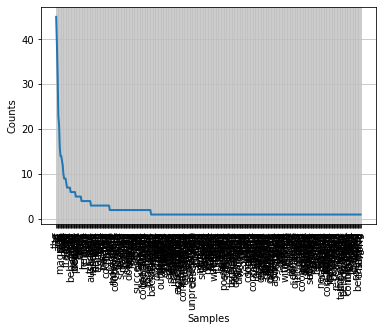

In [16]:
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

fdist = FreqDist(tokens)

fdist.plot(len(fdist),cumulative=False)
plt.show()

Visualizar la frecuencia de cada palabra a través de un gráfico no es una opción viable, ya que existen demasiadas muestras. Sin embargo, podemos hacernos una pequela idea tomando solo 40.

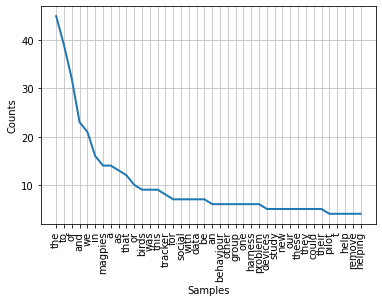

<Figure size 2160x7200 with 0 Axes>

In [17]:
fdist.plot(40,cumulative=False)
plt.figure(figsize=(30,100))
plt.show()

También podemos adquirir más información acerca de las palabras del texto comprobando cuáles son las que más aparecen

In [18]:
for word, freq in fdist.most_common(10):
    print(f"{word}: {freq}")

the: 45
to: 39
of: 32
and: 23
we: 21
in: 16
magpies: 14
a: 14
as: 13
that: 12


Como podemos ver, entre estas palabras hay sobre todo artículos, preposiciones y conectores. Son palabras "comodín", que tienen significados muy flexibles o ambiguos y que sirven para unir palabras entre sí. Por tanto, las palabras más frecuentes del texto no nos aportan mucha información acerca de su contenido.

## Exercici 3
Treu les stopwords i realitza stemming al teu conjunt de dades.

Para obtener más información acerca del contenido del texto, elimino las "stopwords" del conjunto de tokens. De esta forma, podré analizar las palabras restantes, las cuales no son de uso genérico, y así obtener idea más concreta del contenido del texto.

In [19]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

tokens_without_stopwords = []

for token in tokens:
    if token not in stop_words:
        tokens_without_stopwords.append(token)

In [20]:
index = ['Number of tokens']

df_num_words = pd.DataFrame({}, index=index)

df_num_words['With stopwords'] = len(tokens)
df_num_words['Without stopwords'] = len(tokens_without_stopwords)
display(df_num_words)

,With stopwords,Without stopwords
Number of tokens,925,515


Como vemos, el número de tokens se reduce considerablemente, casi a la mitad, al eliminar las "stopwords".

Volvemos a comprobar cuáles son las palabras más frecuentes

In [21]:
fdist = FreqDist(tokens_without_stopwords)
print(fdist.most_common(20))

[('magpies', 14), ('birds', 9), ('tracker', 8), ('social', 7), ('data', 7), ('behaviour', 6), ('group', 6), ('one', 6), ('harness', 6), ('problem', 6), ('devices', 5), ('study', 5), ('new', 5), ('could', 5), ('pilot', 4), ('help', 4), ('remove', 4), ('helping', 4), ('also', 4), ('tracking', 3)]


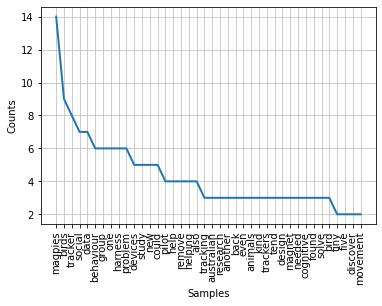

<Figure size 2160x7200 with 0 Axes>

In [22]:
fdist.plot(40,cumulative=False)
plt.figure(figsize=(30,100))
plt.show()

Estas palabras nos aportan una visión mucho más concreta. Podemos deducir que el texto trata sobre aves, y de urracas en especial, y del estudio de su comportamiento.

Además, la frecuencia de las palabras está mucho más equilibrada (de 14 a 1 ocurrencias) que cuando estábamos considerando las "stopwords" (de 45 a 1 ocurrencias).

A continuación realizo una normalización del léxico a través de dos técnicas, stemming y lemmatizing, para tratar como iguales las palabras con la misma raíz semántica.

**Stemming**

In [23]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

stemmer = PorterStemmer()

stemmed_words=[]
for token in tokens_without_stopwords:
    stemmed_words.append(stemmer.stem(token))
    
print(stemmed_words[:50])

['attach', 'tini', 'backpacklik', 'track', 'devic', 'five', 'australian', 'magpi', 'pilot', 'studi', 'expect', 'discov', 'entir', 'new', 'social', 'behaviour', 'rare', 'seen', 'bird', 'goal', 'learn', 'movement', 'social', 'dynam', 'highli', 'intellig', 'bird', 'test', 'new', 'durabl', 'reusabl', 'devic', 'instead', 'bird', 'outsmart', 'us', 'new', 'research', 'paper', 'explain', 'magpi', 'began', 'show', 'evid', 'cooper', 'rescu', 'behaviour', 'help', 'remov', 'tracker']


**Lemmatizing**

In [24]:
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

lemmatized_words=[]
for token in tokens_without_stopwords:
    lemmatized_words.append(lemmatizer.lemmatize(token))

print(lemmatized_words[:50])

['attached', 'tiny', 'backpacklike', 'tracking', 'device', 'five', 'australian', 'magpie', 'pilot', 'study', 'expect', 'discover', 'entirely', 'new', 'social', 'behaviour', 'rarely', 'seen', 'bird', 'goal', 'learn', 'movement', 'social', 'dynamic', 'highly', 'intelligent', 'bird', 'test', 'new', 'durable', 'reusable', 'device', 'instead', 'bird', 'outsmarted', 'u', 'new', 'research', 'paper', 'explains', 'magpie', 'began', 'showing', 'evidence', 'cooperative', 'rescue', 'behaviour', 'help', 'remove', 'tracker']


El stemmer y el lemmatizer tratan las palabras de forma diferente. El stemmer no tiene en cuenta el contexto y suprime los sufijos o morfemas de forma generalista; el lemmatizer, en cambio, sí que tiene en cuenta el contexto y convierte las palabras al lema o palabra de la que derivan.

Compruebo cuáles son los resultados de aplicar cada normalización léxica 

In [25]:
index = ['Number of words']

df_num_words = pd.DataFrame({}, index=index)

df_num_words['Before normalization'] = len(set(tokens_without_stopwords))
df_num_words['Stemmer'] = len(set(stemmed_words))
df_num_words['Lemmatizer'] = len(set(lemmatized_words))

display(df_num_words)

,Before normalization,Stemmer,Lemmatizer
Number of words,341,301,332


En este caso, el stemmer aplica una reducción mayor al total de las palabras. El lemmatizer, en cambio, es más sensible a diferencias de contexto y significado y establece clasificaciones más precisas.

## Exercici 4
Realitza sentiment analysis al teu conjunt de dades.

In [221]:
df_tweets = pd.read_csv('tweets.csv', encoding='latin1')
df_tweets = df_tweets.sample(1000, random_state=27)
display(df_tweets)

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1459036,4,2063718702,Sun Jun 07 03:48:23 PDT 2009,NO_QUERY,aileenvaldez,Just waiting for the Day When im Sitting on t...
981663,4,1834132991,Mon May 18 01:45:20 PDT 2009,NO_QUERY,lassirra,@Medros Np I just remembered seeing the post ...
867115,4,1677720634,Sat May 02 03:37:08 PDT 2009,NO_QUERY,Imatoughcookie,@captainspecial HI CONRAD!!!! How are you LOVI...
21284,0,1557250652,Sun Apr 19 02:55:50 PDT 2009,NO_QUERY,gradynotgrady,@jongulergrey IRL mod privs revoked
1591316,4,2191545866,Tue Jun 16 05:30:02 PDT 2009,NO_QUERY,FoTizzle,@JessAttack I gotz it even tho we both no i c...
...,...,...,...,...,...,...
441864,0,2067123159,Sun Jun 07 11:47:20 PDT 2009,NO_QUERY,nikosi,awwww...i forgot i don't have car
357133,0,2044565865,Fri Jun 05 09:32:26 PDT 2009,NO_QUERY,superchrisss,"@Pixleh Suck You must of got the collectors, ..."
113692,0,1825934043,Sun May 17 07:15:43 PDT 2009,NO_QUERY,Vivhy,"It's sunday, nothing good on TV, no internet a..."
1155422,4,1979007626,Sun May 31 01:16:02 PDT 2009,NO_QUERY,rbuerckner,@brookehaskins Oh... I sent you an email on fa...


Primero, tengo que editar la estructura del dataframe para incluir el nombre de las columnas sin perder la información del primer registro.

In [222]:
cols = []

for col in df_tweets.columns:
    cols.append(col)

df_tweets = df_tweets.rename({
    df_tweets.columns[0]: 'sentiment', 
    df_tweets.columns[1]: 'id', 
    df_tweets.columns[2]: 'datetime', 
    df_tweets.columns[3]: 'query', 
    df_tweets.columns[4]: 'username', 
    df_tweets.columns[5]: 'text'}, axis=1)


df_aux = pd.DataFrame({})

print(cols)
for i in range(len(cols)):
    df_aux[f"{df_tweets.columns[i]}"] = [cols[i]]

display(df_aux)

df_tweets = pd.concat([df_tweets, df_aux], join="inner")
display(df_tweets)

['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY', '_TheSpecialOne_', "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"]


,sentiment,id,datetime,query,username,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."


,sentiment,id,datetime,query,username,text
1459036,4,2063718702,Sun Jun 07 03:48:23 PDT 2009,NO_QUERY,aileenvaldez,Just waiting for the Day When im Sitting on t...
981663,4,1834132991,Mon May 18 01:45:20 PDT 2009,NO_QUERY,lassirra,@Medros Np I just remembered seeing the post ...
867115,4,1677720634,Sat May 02 03:37:08 PDT 2009,NO_QUERY,Imatoughcookie,@captainspecial HI CONRAD!!!! How are you LOVI...
21284,0,1557250652,Sun Apr 19 02:55:50 PDT 2009,NO_QUERY,gradynotgrady,@jongulergrey IRL mod privs revoked
1591316,4,2191545866,Tue Jun 16 05:30:02 PDT 2009,NO_QUERY,FoTizzle,@JessAttack I gotz it even tho we both no i c...
...,...,...,...,...,...,...
357133,0,2044565865,Fri Jun 05 09:32:26 PDT 2009,NO_QUERY,superchrisss,"@Pixleh Suck You must of got the collectors, ..."
113692,0,1825934043,Sun May 17 07:15:43 PDT 2009,NO_QUERY,Vivhy,"It's sunday, nothing good on TV, no internet a..."
1155422,4,1979007626,Sun May 31 01:16:02 PDT 2009,NO_QUERY,rbuerckner,@brookehaskins Oh... I sent you an email on fa...
628672,0,2231381160,Thu Jun 18 18:27:58 PDT 2009,NO_QUERY,eilo18,"@xDorianGrayx hey man, sorry about this horrib..."


In [223]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001 entries, 1459036 to 0
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  1001 non-null   object
 1   id         1001 non-null   object
 2   datetime   1001 non-null   object
 3   query      1001 non-null   object
 4   username   1001 non-null   object
 5   text       1001 non-null   object
dtypes: object(6)
memory usage: 54.7+ KB


In [224]:
df_tweets["sentiment"] = pd.to_numeric(df_tweets["sentiment"])

Elimino las columnas que no aportan nada al análisis. Solo necesito los textos y la valoración.

In [225]:
df_tweets = df_tweets.drop(['id', 'datetime', 'query', 'username'], axis=1)
display(df_tweets.columns)

Index(['sentiment', 'text'], dtype='object')

Compruebo la existencia de valores nulos

In [226]:
df_tweets.isnull().values.any()

False

Reviso que los tipos de valoración estén equilibrados en el dataset

In [227]:
df_tweets['sentiment'].value_counts()

4    506
0    495
Name: sentiment, dtype: int64

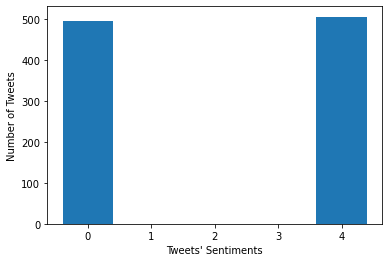

In [228]:
sentiment_count = df_tweets.groupby('sentiment').count()

plt.bar(sentiment_count.index.values, sentiment_count['text'])
plt.xlabel('Tweets\' Sentiments')
plt.ylabel('Number of Tweets')
plt.show()

Las valoraciones en este dataset están muy polarizadas. En una escala de 0 a 4, los mensajes solo están valorados con las puntuaciones más extremas. De todas formas, el dataset sigue siendo útil, ya que podemos interpretar la clasificación simplemente como positivo y negativo.

A continuación crearé dos modelos, Bag of Words y TF-IDF para predecir la valoración de los tweets. Para ambos he utilizado un GridSearch, que me permite tener en cuenta diferentes tokenizers a la hora de vectorizar el texto. He tomado esta decisión porque quiero comparar si el resultado es mejor empleando TweetTokenizer, un tokenizer especialmente creado para tweets, que elimina las menciones del texto, o un tokenizer básico a partir de RegExp

**Bag of words**

In [244]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize.casual import TweetTokenizer, casual_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.naive_bayes import MultinomialNB
from nltk.stem.wordnet import WordNetLemmatizer

steps = [
    ('vectorizer', CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1,1))),
    ('classifier', MultinomialNB())
]

pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(df_tweets['text'], df_tweets['sentiment'], test_size=0.3, random_state=27)

parametres = {'vectorizer__tokenizer': (
    TweetTokenizer(preserve_case=True, reduce_len=True, strip_handles=True, match_phone_numbers=True).tokenize,
    TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True, match_phone_numbers=True).tokenize,
    RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize,
    casual_tokenize
),
              'classifier__fit_prior': (
                  True,
              )
             }

grid = GridSearchCV(pipeline, param_grid=parametres, cv=5)
grid.fit(X_train, y_train)
bow_accuracy = grid.score(X_test,y_test)
print(grid.best_params_)

{'classifier__fit_prior': True, 'vectorizer__tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>}


Compruebo el resultado de la vectorización con los parámetros óptimos

In [230]:
tknzr = RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize

bow = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1,1), tokenizer=tknzr)
tweets_bow = bow.fit_transform(df_tweets['text'])

print(tweets_bow.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


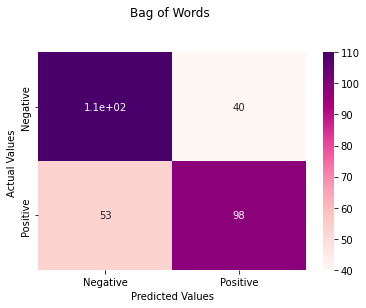

In [231]:
y_pred = grid.predict(X_test)
y_true = y_test

cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, cmap='RdPu')
ax.set_title('Bag of Words \n\n')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['Negative','Positive'])
plt.show()

Podemos advertir cierta tendencia en el modelo Bag of Words a predecir valoraciones negativas para los mensajes.

**TF-IDF**

Antes de utilizar los tweets para entrenar el modelo, he "limpiado" las menciones. El vectorizador de Bag of Words ya hace un preprocesamiento para eliminar específico para Twitter para eliminar las menciones, pero el del modelo TF-IDF no.

In [237]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import RegexpTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

steps = [
    ('vectorizer', TfidfVectorizer(lowercase=True, stop_words='english')),
    ('classifier', MultinomialNB())
]

pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(df_tweets['text'], df_tweets['sentiment'], test_size=0.3, random_state=27)

parametres = {'vectorizer__tokenizer': (
    TweetTokenizer(preserve_case=True, reduce_len=True, strip_handles=True, match_phone_numbers=True).tokenize,
    TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True, match_phone_numbers=True).tokenize,
    RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize,
    casual_tokenize
),
              'classifier__fit_prior': (
                  True,
              )
             }

grid = GridSearchCV(pipeline, param_grid=parametres, cv=5)
grid.fit(X_train, y_train)
tfidf_accuracy = grid.score(X_test,y_test)

print(grid.best_params_)

{'classifier__fit_prior': True, 'vectorizer__tokenizer': <bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>}


Compruebo el resultado de la vectorización con los parámetros óptimos

In [234]:
from sklearn.feature_extraction.text import TfidfVectorizer

tknzr = RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize

tfidf = TfidfVectorizer(lowercase=True, stop_words='english', tokenizer=tknzr)
tweets_tfidf = tfidf.fit_transform(df_tweets['text'])

print(tweets_tfidf.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


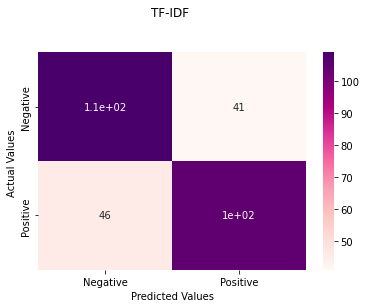

In [235]:
y_pred = grid.predict(X_test)
y_true = y_test

cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, cmap='RdPu')
ax.set_title('TF-IDF \n\n')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['Negative','Positive'])
plt.show()

En el modelo TF-IDF también apreciamos cierta tendencia a predecir valoraciones negativas, aunque en menor medida.

Comparo las métricas de accuracy de ambos modelos

In [211]:
index = ['Accuracy']

df_scores = pd.DataFrame({}, index=index)

df_scores['Bag of Words'] = bow_accuracy
df_scores['TF-IDF'] = tfidf_accuracy

display(df_scores)

,Bag of Words,TF-IDF
Accuracy,0.69103,0.710963


Por poca diferencia, TF-IDF es el modelo con una puntación de accuracy más alta. Ninguno de los modelos ha obtenido una puntuación muy cercana a 1, lo que indica que podrían mejorarse con algún proceso de ingeniería de variables u otras técnicas de preprocesamiento de los textos.